In [57]:
# importamos librerías
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

# EDA y limpieza de datos

Para poder preparar los datos para la modelación es fundamental realizar un análisis exploratorio y posteriormente realizar la limpieza correspondiente. El primer paso sería revisar los valores nulos, sin embargo, la fuente de esta base de datos comenta que no hay valores nulos, por lo que en este caso podremos saltarnos este paso. Después revisaremos valores atípicos o números que no tengan mucho sentido, para lograr esto dividiremos los datos en dos categorías:

1. Columnas numéricas:
    - Buscaremos revisar cualquier número negativo, o límites de crédito muy altos que puedan afectar el desempeño del modelo
2. Columnas categóricas
    - Buscaremos entradas con categorías no descritas y verificar imbalance de clases

Posteriormente se realizará un análisis de correlación entre las variables y la preparación de los datasets correspondientes para usar en la sección de modelaje.  

In [3]:
# leemos datos, usamos header = 1 ya que la primera fila no contiene los nombres reales de las columnas
df = pd.read_csv('default of credit card clients.csv', header=1)
# mostramos las primeras filas del DataFrame
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# separamos las columnas categóricas y numéricas
categoric_cols = ['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
numeric_cols = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
df_cat = df[categoric_cols]
df_num = df[numeric_cols]

## Variables numéricas

Para analizar las variables numéricas usaremos un boxplot, esto nos ayudará a revisar valores atípicos y valores negativos

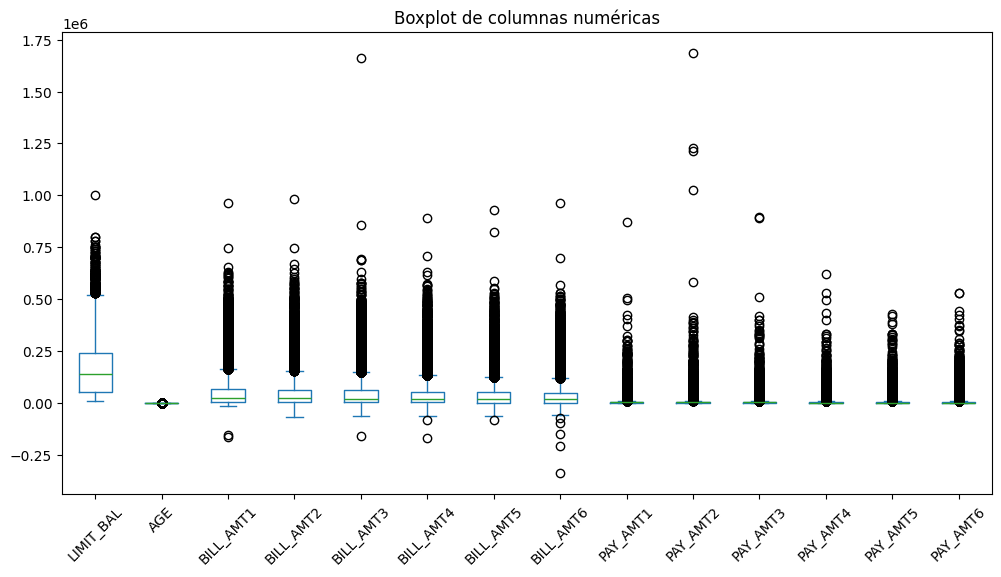

In [5]:
df_num.select_dtypes(include='number').plot.box(figsize=(12, 6))
plt.title("Boxplot de columnas numéricas")
plt.xticks(rotation=45)
plt.show()

Se pueden observar dos cosas:

- La presencia de algunos outliers en un par de variables, sobre todo, notando que la mayor línea de crédito otorgada es de $1,000,000 y unos valores en 'BILL_AMT' o 'PAY_AMT' sobre pasan este número lo que significaría unas personas gastaron más de lo que se les permitía. Sin más contexto de la base de datos estos valores por encima de $1,000,000 se eliminarán.

- Hay variables que contienen valores negativos, a pesar de que estos podrían tratarse de casos en los que el estado de cuenta tenía saldo a favor ya sea por reembolsos o pagos superiores al necesario, también los eliminaré por simplicidad.



In [6]:
for col in df_num.columns:
    df = df[(df[col] >= 0) & (df[col] <= 1000000)]

## Variables categóricas

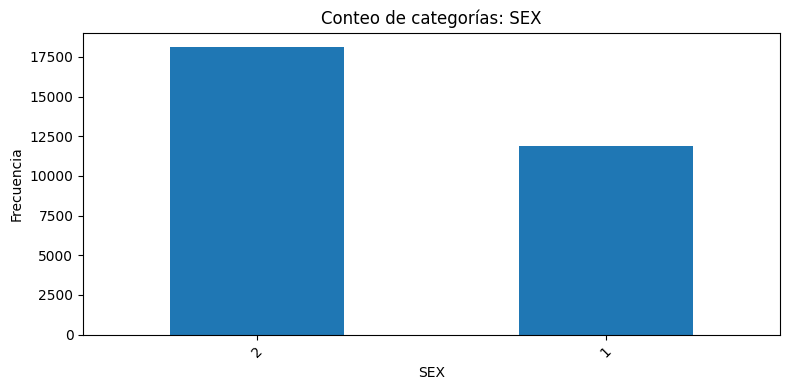

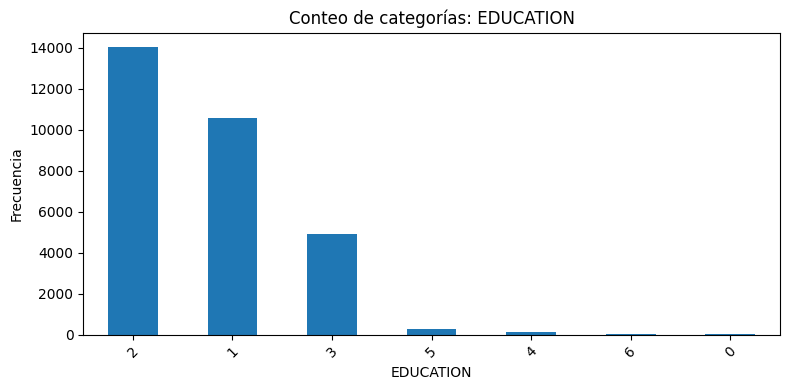

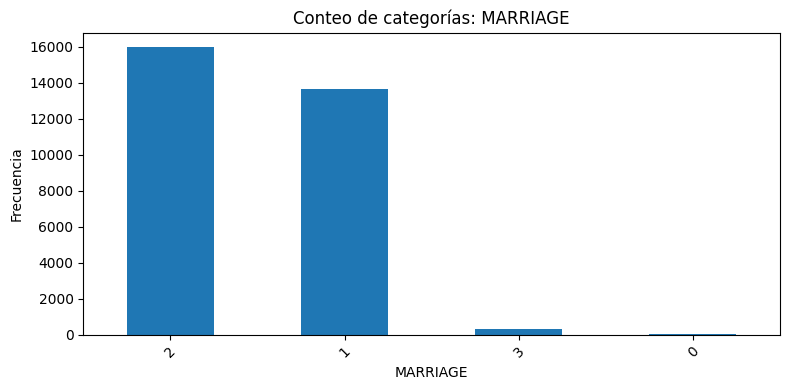

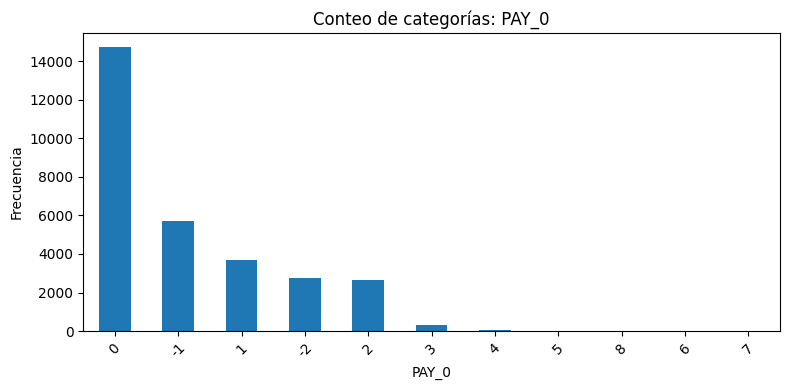

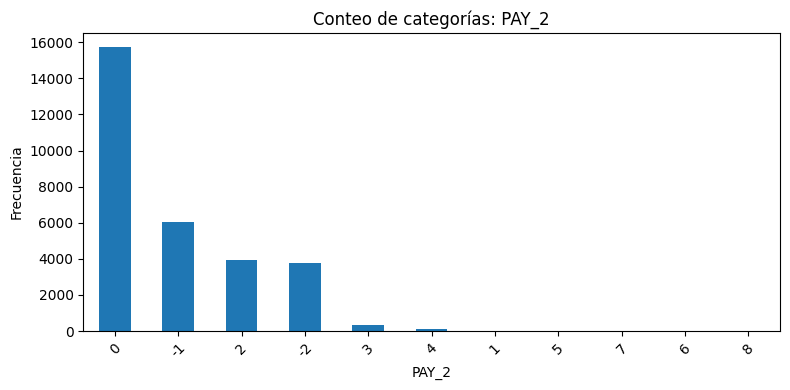

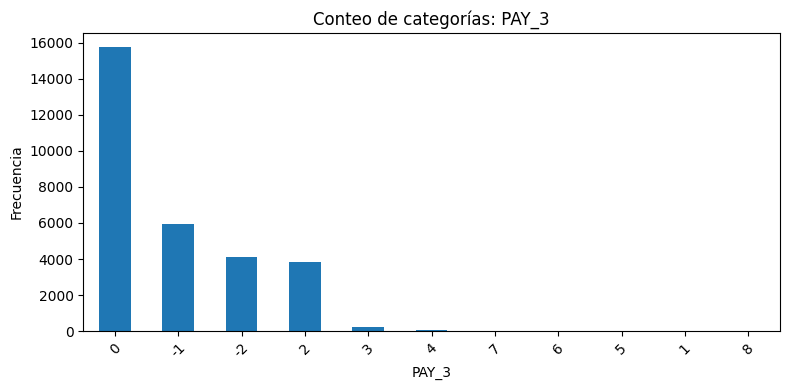

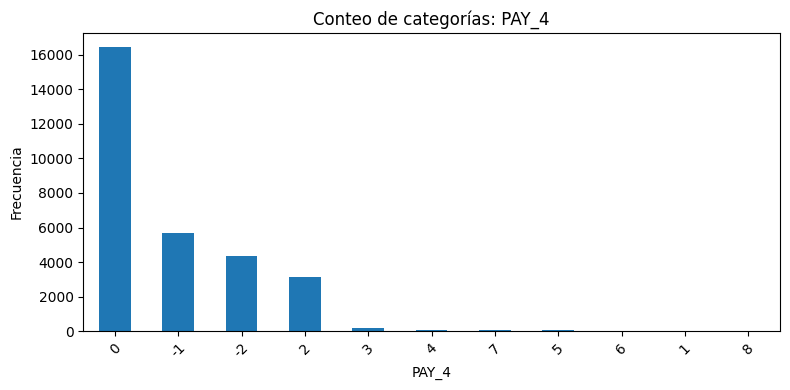

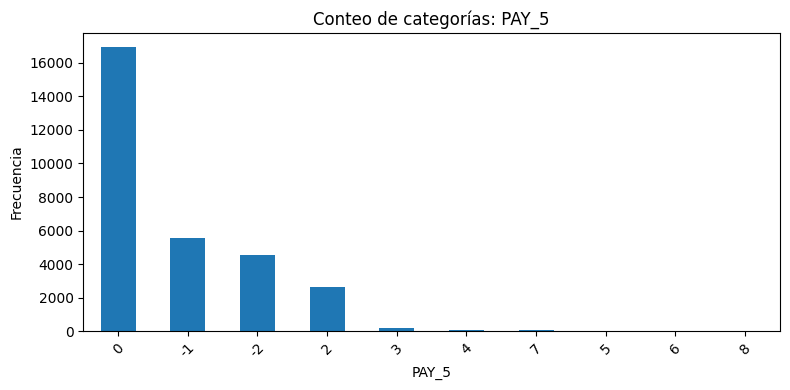

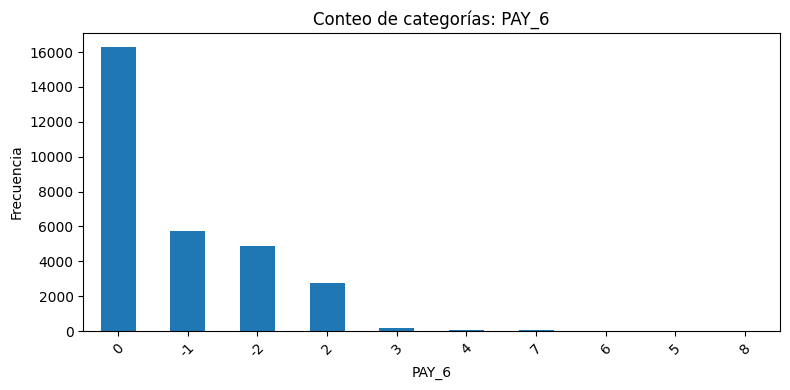

In [7]:
for col in df_cat.columns:
    plt.figure(figsize=(8, 4))
    df_cat[col].value_counts().plot(kind='bar')
    plt.title(f'Conteo de categorías: {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Se puede apreciar que todas las variables a excepción de 'SEX' contienen una categoría no descrita en el catálogo, por ejemplo, todas contienen la categoría 0, la cual no se sabe qué significa, además, en ciertos casos esta es la que más entradas contiene.

Debido a la falta de información sobre esta categoría y algunas otras (como -2), se eliminarán, quedando sólo la información que **sí** se sabe qué significa en base al catálogo proporcionado.

In [8]:
df = df[~df[categoric_cols].isin([0, -2]).any(axis=1)].copy()

## Resultados posteriores a limpieza

In [9]:
len(df)

3807

Se puede apreciar que después de la limpieza el dataset se redujo de 30,000 entradas a casi 4,000, a pesar de que la cantidad es significativamente menor, se puede estar 100% seguro de que la integridad de esta data limpia es mejor a la anterior (reiterando que es en base a la información proporcionada)

## Análisis de Correlación

Una parte fundamental del análisis de datos es análizar la correlación entre las variables, específicamente entre las variables objetivo y las posibles variables categóricas, esto servirá para preveer posibles relaciones lineales entre estas e identificar variables predictoras

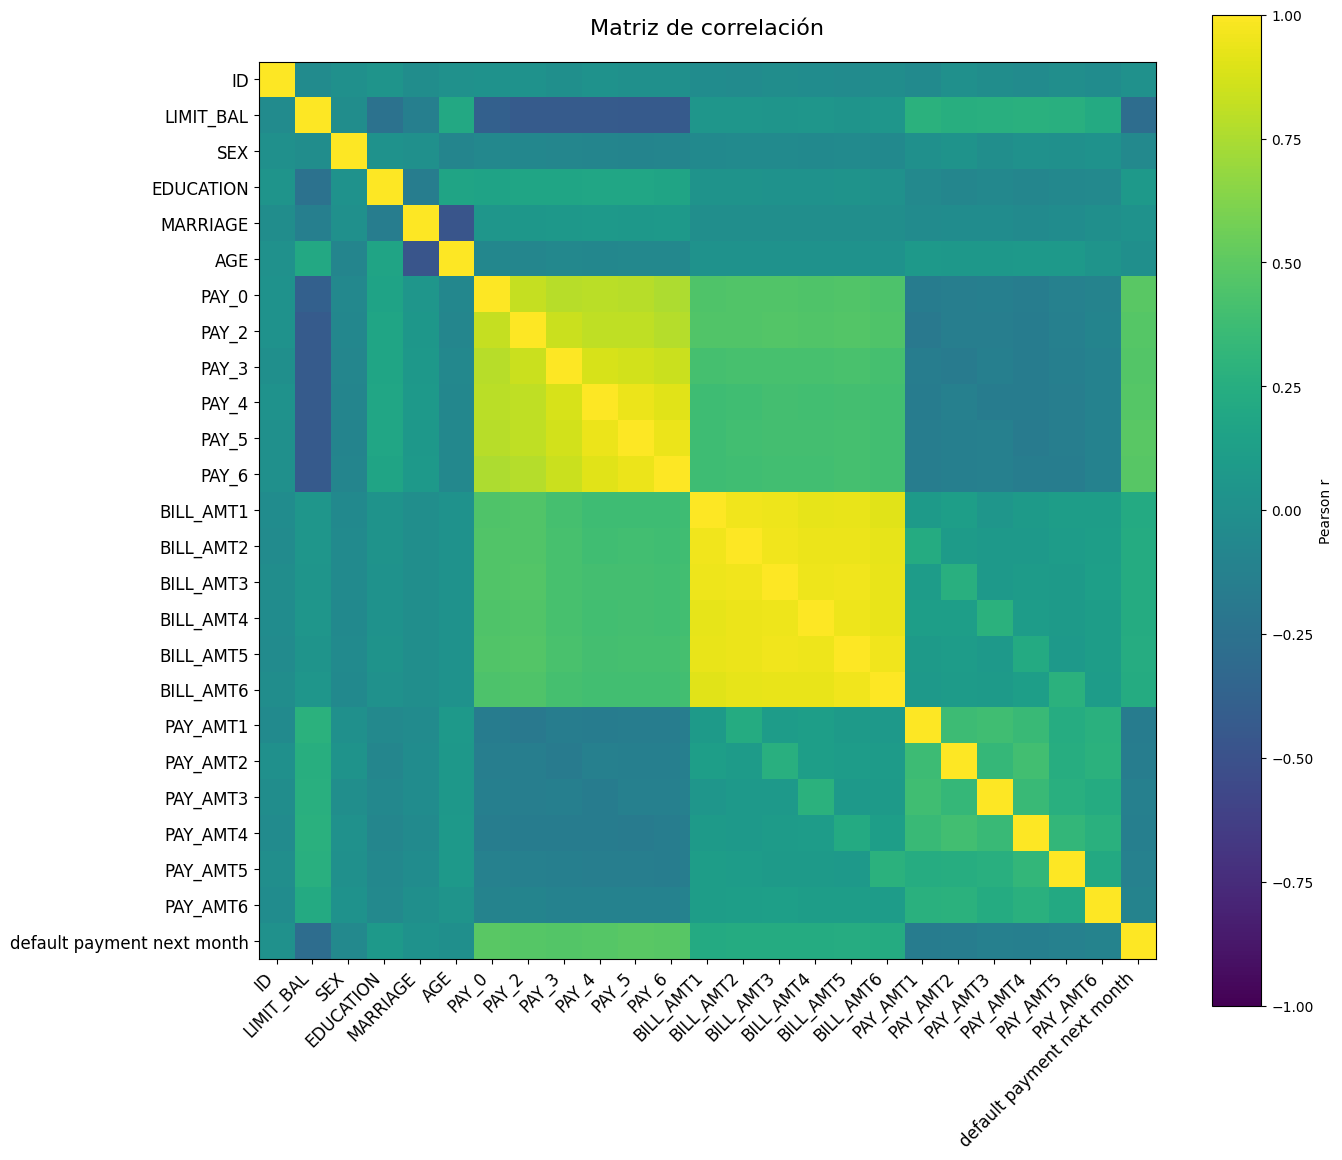

In [10]:
# Calcula la matriz de correlación con el método de Pearsons
corr_matrix = df.corr(method="pearson")
# Mostramos con mapa de calor
plt.figure(figsize=(14, 12), dpi=100)
plt.imshow(corr_matrix, vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.xticks(
    range(len(corr_matrix.columns)),
    corr_matrix.columns,
    rotation=45,
    ha="right",
    fontsize=12
)
plt.yticks(
    range(len(corr_matrix.columns)),
    corr_matrix.columns,
    fontsize=12
)
plt.title("Matriz de correlación", fontsize=16, pad=20)
plt.tight_layout()
plt.show()


Es un poco difícil de analizar la correlación entre las variables objetivo (en este caso sólo PAY_AMT4 al ser variable continua) y las posibles predictoras, por lo que mejor se mostrará individualmente la correlación entre estas.

In [11]:
# Correlación para PAY_AMT4
corr1 = corr_matrix["PAY_AMT4"].sort_values(ascending=False)
print(corr1)

PAY_AMT4                      1.000000
PAY_AMT2                      0.390683
PAY_AMT3                      0.358833
PAY_AMT1                      0.356559
PAY_AMT5                      0.322452
LIMIT_BAL                     0.271667
PAY_AMT6                      0.268420
BILL_AMT5                     0.223424
BILL_AMT6                     0.119539
BILL_AMT4                     0.106430
BILL_AMT3                     0.099940
BILL_AMT1                     0.086298
BILL_AMT2                     0.082978
AGE                           0.081456
SEX                           0.013336
ID                           -0.031569
MARRIAGE                     -0.045375
EDUCATION                    -0.079165
default payment next month   -0.136444
PAY_0                        -0.151792
PAY_6                        -0.153220
PAY_4                        -0.156518
PAY_2                        -0.157770
PAY_3                        -0.158903
PAY_5                        -0.171175
Name: PAY_AMT4, dtype: fl

La correlación lineal entre todas las variables y PAY_AMT4 es muy baja, no hay correlación fuerte ni positiva ni negativa, por esta razón se optará por **no realizar modelos de regresión lineal ya que los resultados serían malos**

# Preparación de datasets

Una vez hecho un análisis exploratorio de los datos y la limpieza apropiada, se crearán dos datasets diferentes

1. El primero para predecir la variable 'PAY_AMT4' (cantidad pagada en junio), este tendrá las variables correspondientes a la cantidad a pagar y el pago realizado de los meses de abril y mayo, no se usarán meses posteriores ya que se habría data leakage; además de variables como la Edad, sexo, etc. Por otro lado se hará un proceso de feature engineering para ayudar a los modelos a mejorar las predicciones, estas características extras serán:
    - Utilización de crédito: Relación saldo / límite. De esta manera discrimina entre clientes buenos y sobre endeudados
    - Tendencia de saldo: Revisar si la deuda viene subiendo o viene bajando

    Por último, para algunas variables categóricas se usará la función de get_dummies, esto ayudará a los modelos a tener un mejor desempeño

2. El segundo para predecir la variable 'default.payment.next.month' contendrá todas las variables (salvo el ID que sólo sirve como identificador), con este se realizarán modelos de clasificación.

In [50]:
# creamos dataset para regresión (la única variable a incluir de junio es PAY_AMT4 ya que es la objetivo)
df_reg = df[['PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT5', 'BILL_AMT6','LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_5','PAY_6']].copy()
# relación saldo / límite
df_reg['USED_5'] = df_reg['BILL_AMT5'] / df_reg['LIMIT_BAL']
df_reg['USED_6'] = df_reg['BILL_AMT6'] / df_reg['LIMIT_BAL']
# tendencia saldo
df_reg['BILL_TREND'] = df_reg['BILL_AMT5'] - df_reg['BILL_AMT6']
# creación de dummies para variables categóricas
df_reg = pd.get_dummies(df_reg, columns = ['EDUCATION','MARRIAGE'])

In [51]:
# creación del dataset para clasificación
df_clf = df.drop('ID',axis = 1)

# Modelación

En esta sección se presentan los modelos de ML usados para predecir las dos variables de interés **PAY_AMT4** y **default payment next month**

## Modelos de regresión

Se harán los siguientes 4 modelos para tratar de predecir la cantidad que el usuario pagará en el mes de junio (PAY_AMT4)

- Random Forest: ensamble de muchos árboles de decisión entrenados con bagging que promedia sus predicciones.
- Gradient Boosting: árboles sucesivos que corrigen los errores del anterior sumando pequeñas mejoras graduales.
- XGBoost: versión optimizada de gradient boosting con regularización y particionado por columnas para mayor rapidez.
- Red Neuronal (MLP): capas densas que aprenden relaciones no lineales ajustando pesos mediante retro-propagación.

Se usarán como métricas de evaluación:

- MAE: error absoluto medio, es decir en promedio por cuánto se equivoca el modelo.
- RMSE: raiz del error cuadrado, esto nos dice en promedio cuánto se equivoca el modelo en el peor de los casos.
- $R^2$: el coeficiente de regresión, qué tan bien se ajusta la regresión a los datos reales

In [39]:
# realizamos train/test split
target = 'PAY_AMT4'
X = df_reg.drop(columns=[target]).values
y = df_reg[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# función para mostrar facilmente resultados de los modelos
def eval_model(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) 
    r2   = r2_score(y_true, y_pred)
    print(f"{name:<15} | MAE: {mae:,.0f} | RMSE: {rmse:,.0f} | R²: {r2:.3f}")

RandomForest    | MAE: 1,811 | RMSE: 7,455 | R²: 0.565


In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=25,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
eval_model("RandomForest", y_test, rf.predict(X_test))

In [41]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gbr.fit(X_train, y_train)
eval_model("GradBoosting", y_test, gbr.predict(X_test))


GradBoosting    | MAE: 1,325 | RMSE: 6,206 | R²: 0.699


In [43]:
# Extreme Gradient Boosting Regressor
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
eval_model("XGBoost", y_test, xgb.predict(X_test))

XGBoost         | MAE: 1,219 | RMSE: 6,138 | R²: 0.705


In [44]:
# Neural Network Regressor

# escalamiento de variables
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn  = scaler.transform(X_test)

# Arquitectura de la red
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)), # primera capa oculta
    keras.layers.Dense(32, activation='relu'), # segunda capa oculta
    keras.layers.Dense(1) # capa de salida
])

# Compilación del modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Entrenamiento del modelo
model.fit(
    X_train_nn, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=0
)
pred_nn = model.predict(X_test_nn).flatten()
eval_model("NeuralNet", y_test, pred_nn)

/Users/axllopez/Desktop/Bluetab_assesment/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
NeuralNet       | MAE: 1,480 | RMSE: 6,238 | R²: 0.695


## Modelos de clasificación

Se usarán los mismos 4 modelos que en la regresión, ya que, estos tienen su versión en 'clasificador', para la red neuronal la diferencia será la función de activación, la cual será la sigmoide, útil para temas de clasificación binaria.

Se usarán como métricas de evaluación:

- Accuracy: proporción de casos bien clasificados sobre el total
- ROC-AUC: probabilidad de que el modelo puntúe más alto a un positivo que a un negativo
- F1-score: media armónica entre precisión y recall, balance entre falsos positivos y falsos negativos
- Matriz de confusión: tabla 2x2 mostrando TP, FP, TN y FN

In [55]:
# realizamos train/test split
target = 'default payment next month'
X = df_clf.drop(columns=[target]).values
y = df_clf[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [56]:
# función para evaluar modelos fácilmente
def eval_cls(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    f1  = f1_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred)
    print(f"{name:<15} | Acc: {acc:.3f} | ROC-AUC: {auc:.3f} | F1: {f1:.3f}")
    print("Confusion matrix:\n", cm, "\n")

In [58]:
# Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=20,
    class_weight='balanced', n_jobs=-1, random_state=42
) # class_weight='balanced' para manejar el desbalanceo de clases
rf.fit(X_train, y_train)
eval_cls("RandomForest",y_test,rf.predict(X_test),rf.predict_proba(X_test)[:, 1])

RandomForest    | Acc: 0.776 | ROC-AUC: 0.832 | F1: 0.703
Confusion matrix:
 [[389  94]
 [ 77 202]] 



In [59]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=3,
    subsample=0.8, random_state=42
)
gbc.fit(X_train, y_train)
eval_cls("GradBoosting",y_test,gbc.predict(X_test),gbc.predict_proba(X_test)[:, 1])

GradBoosting    | Acc: 0.783 | ROC-AUC: 0.827 | F1: 0.696
Confusion matrix:
 [[408  75]
 [ 90 189]] 



In [62]:
pos_w = (y_train == 0).sum() / (y_train == 1).sum() # calculamos el peso de la clase positiva
xgb = XGBClassifier(
    n_estimators=800, learning_rate=0.03, max_depth=4,
    subsample=0.9, colsample_bytree=0.8,
    objective='binary:logistic', scale_pos_weight=pos_w,
    eval_metric='auc', random_state=42
)
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose = False
)
eval_cls("XGBoost",y_test,(xgb.predict_proba(X_test)[:, 1] > 0.5).astype(int),xgb.predict_proba(X_test)[:, 1])

XGBoost         | Acc: 0.773 | ROC-AUC: 0.825 | F1: 0.700
Confusion matrix:
 [[387  96]
 [ 77 202]] 



In [63]:
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)
X_test_nn  = scaler.transform(X_test)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid') # función de salida de clasificación binaria
])
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(
    X_train_nn, y_train,
    epochs=100, batch_size=32, validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=0
)
proba_nn = model.predict(X_test_nn).flatten()
pred_nn  = (proba_nn > 0.5).astype(int)
eval_cls("NeuralNet", y_test, pred_nn, proba_nn)

/Users/axllopez/Desktop/Bluetab_assesment/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
NeuralNet       | Acc: 0.787 | ROC-AUC: 0.822 | F1: 0.710
Confusion matrix:
 [[402  81]
 [ 81 198]] 



# Conclusiones

**A nivel técnico**

Los modelos para predecir las variables PAY_AMT4 y default payment next month muestran buenos resultados, a pesar de la poca cantidad de datos a disposición, lo cual se debe al proceso de limpieza realizado que eliminó una cantidad de datos importante, sin embargo, era necesario debido a la información que se tenía de la base de datos y para asegurar la integridad en estos.

En cuanto a los modelos de regresión todos muestran un coeficiente de $R^2$ de alrededor de 0.7, a excepción de Random Forest que es menor, esto se debe a que los otros modelos usados captan mejor las diferencias y las importancias de variables categóricas (en el caso de regresores) y puede manejar este tipo de combinaciones de tipos de variables de manera efectiva. Por otro lado, las métricas de MAE y RMSE de igual manera son buenas, considerando que hay clientes que pueden llegar a hacer pagos de cientos de miles de dólares, que estas métricas no se disparen indica que los modelos sí están prediciendo cercano a la realidad.  

Los modelos de clasificación muestran resultados similares de casi un 80% de accuracy entre sí, un ROC-AUC de 0.8 y un f1-score de 0.71. Estas métricas de igual manera son buenas considerando que hay un ligero desbalance de clases (0 contiene más entradas que 1) y la cantidad de datos que se tiene, nuevamente debido a la limpieza previa de estos.

En general ambas predicciones muestran buenos y prometedores resultados, además, estos se pueden mejorar significativamente usando técnicas como Grid Search para la optimización de hiper parámetros o con arquitecturas un poco más profundas y complejas para las redes neuronales. Además, la integridad de los datos siempre va a ser clave en este tipo de tareas, debido a esto, la base de datos se redujo bastante, ya que, en base a la información disponible no se podían dejar entradas con ciertas características. Esto significa que si los datos y la información de estos estuviera más completa, los modelos recibirán más input para el proceso de entrenamiento lo que mejoraría los resultados de estos.

**A nivel de negocio**

- Mejor gestión del riesgo de crédito: gracias a la métrica ROC-AUC (alrededor de 80%) se puede priorizar al 20% clientes más riesgosos y anticipar la mayoría de los posibles retrasos o faltas de pago, permitiendo así ajustar líneas de crédito o solicitar garantías.

- Pronóstico de liquidez y provisiones: La predicción del pago del mes de junio ($R^2$ ≈ 0.70) ofrece una estimación fiable de los flujos de pago mensuales, facilitando planes de tesorería y el cálculo más preciso de reservas contables.

- Optimización de cobranzas: Al saber quiénes y cuánto pagarán, los equipos de recolección pueden enfocar esfuerzos en cuentas con alta probabilidad de impago y alto monto pendiente, reduciendo costos operativos y mejorando la recuperación.

- Segmentación comercial inteligente: Los clientes con baja probabilidad de default y buen historial de pago se identifican rápidamente para ofertas de crédito adicional o productos cruzados, incrementando ingresos sin elevar mucho el riesgo.

- Gobierno de datos como prioridad: El recorte del dataset por calidad evidencia que la rentabilidad de los modelos depende de registros completos y confiables, por lo que, invertir en procesos de captura y validación de datos se traduce directamente en menor riesgo y mejores decisiones.

# Respuesta a preguntas acerca de la solución propuesta

1. De las deficiencias en los datos, ¿cuales y como las identificaste?: Estas las identifiqué de manera visual con gráficos boxplot y de conteo, de esta manera se puede ver rápidamente en las variables numéricas datos atípicos o sin sentido, como lo fue en este caso con gastos elevados o gastos en números negativos, y con las columnas categóricas se podían ver categorías que no se sabe qué significan y no aportan información útil (que se sepa), como el caso de que todas las variables categóricas tenían una categoría "0" y no había información sobré qué significa esta. Otras maneras de identificar estas deficiencias puede ser usando la función .describe(), otro tipo de gráficos, etc.

2. De realizar creación de variables, explica cuales hiciste y por que: Decidí crear variables auxiliares sólo para los modelos de regresión (predecir el pago en junio), ya que la falta de datos podría ocasionar que el modelo no tuviera buenos resultados, al hacer feature engineering le das al modelo nueva información que le pueda servir. En mi caso decidí agregar dos:

    - Utilización de crédito: Relación saldo / límite. De esta manera discrimina entre clientes buenos y sobre endeudados
    - Tendencia de saldo: Revisar si la deuda viene subiendo o viene bajando
    
    Sin embargo, hay múltiples opciones de features que se pueden agregar a los datos para proporcionar información extra a los modelos.

3. De los modelos realizados, ¿como seleccionaste al mejor?: en base a las métricas de evaluación seleccioné al mejor modelo, a pesar de que en ambos casos de regresión y clasificación estas fueron muy similares. En el caso de regresión considero que el XGBoost fue el mejor, ya que tiene el $R^2$ más alto y el MAE más bajo. En los modelos de clasificación considero que el mejor fue la red neuronal (MLP), ya que tiene el accuracy más alto, y no solo eso, el f1-score es bueno también, y en casos de desbalance de clases f1-score es un buen indicador del desempeño del modelo. 

A pesar de esto, todos los modelos son muy mejorables, mediante técnicas como Grid Search o redes neuronales más profundas los resultados y los modelos seleccionados podrían cambiar.

4. ¿Qué desafíos encontraste y cómo los superaste?

El prinicpal desafío que encontré fue relacionado a la calidad de los datos, ya que, como menciono previamente, hay una falta de información considerable en algunos casos, debido a esto, no quise asumir y no consideré cosas que fueran incógnitas o sujetas a suposiciones. 

Otro desafío importante fue durante el desarrollo de modelos de selección, ya que, inicialmente los resultados eran muy malos, fue por esa razón que decidí agregar más variables de las originales, como edad, sexo, etc. así como realizar feature engineering, gracias a esto, los resultados mejoraron significativamente.

# Cuestionario general

1. Establece con tus propias palabras, algunas buenas prácticas y funciones recomendadas para optimizar operaciones de lectura, escritura y manipulación en Spark/PySpark.

    Aún no he ejecutado PySpark en proyectos reales, pero al revisar la guía de rendimiento de Spark y varias notas de la comunidad aprendí que:
    - Conviene grabar y leer en formatos columnares como Parquet para aprovechar rapidez y la compresión, lo que reduce input/output.
    - Particionar los datos con partitionBy sobre las columnas de filtrado frecuente, de modo que cada tarea procese solo los fragmentos relevantes. 
    - Vigilar el número y tamaño de archivos: si el write genera miles de ficheros pequeños, ajustar spark.sql.files.maxPartitionBytes o fusionar particiones con coalesce() para mantener bloques de tamaño estable.
    - Cuando un DataFrame vaya a reutilizarse en varias transformaciones, marcarlo con cache() y lanzar un count() inicial para materializarlo y que las etapas siguientes lean desde memoria en lugar de disco. 

2. Indica las pruebas estadísticas que has utilizado como parte del desarrollo de una solución de ciencia de datos

    Las pruebas estadísticas son claves para entender el comportamiento de los datos, y dentro de soluciones de ciencia de datos son útiles para saber qué modelos puedes usar y cuales puede que tengan buenos resultados. Por ejemplo, para realizar series de tiempo he realizado la prueba Dickey-Fuller Aumentada (ADF), la cual indica si una serie temporal es estacionaria, y de esta manera pude saber si usar un modelo SARIMA/SARIMAX era una opción viable. Otros ejemplo es la prueba chi-cuadrada que sirve para verificar si hay dependencia entre dos variables categóricas, la cual implementé en un estudio sobre hospitalizaciones de COVID-19, y quería ver si el sexo influía en las hospitalizaciones. Así como estas dos he usado múltiples veces ANOVA, Pruebas de normalidad como shapiro-wilk y anderson darling (claves para modelos de regresión), t-student entre otras.

3. En el contexto de Machine Learning y Ciencia de datos, explica:
    - **No Free Lunch Theorem**: no hay ningún modelo que sea bueno y reproducible para todos los casos existentes, cada modelo va a destacar y desempeñar de acuerdo a las estructuras que encajen con sus supuestos, es por eso que el ajuste hiper parámetros y la selección de algoritmo se debe de hacer estudiando cuidadosamente los datos y la estructura de estos y no asumir que un método siempre será el mejor.

    - **Occam’s Razor**: cuando existen dos o varios modelos que explican los datos con precisión similar, se prefiere el más simple, ya sea en cuanto a supuestos, parámetros, etc. ya que es más probable que generalice mejor ejemplos nuevos. Basicamente la complejidad adicional de un modelo no indica que este sea mejor si hay uno más simple con los mismos resultados, y esto puede reducir significativamente costos computacionales.
    
    - **Data Leakage**: esto implica entrenar modelos de Machine Learning con información que este no debería de tener para predecir o clasificar. Esto podría ser entrenar con información del futuro (por ejemplo usar para entrenar los pagos de julio, agosto, etc) o incluso realizar feature engineering, pero de igual manera con información que el modelo no debería de tener, por ejemplo sacar promedios usando valores del futuro. Otro ejemplo sería entrenar el modelo con variables altamente relacionadas con la variable objetivo que **no** se tendrían al momento de realizar predicciones, por ejemplo, si se quiere predecir cuánta gente va a llegar a un restaurante, no podemos usar como variable predictora cuántas mesas están reservadas, ya que esto de igual manera que las personas no se puede saber aún. Caer en Data Leakage causa que los modelos estén overfitted, ocasionando que las predicciones no sean confiables. 